<a href="https://colab.research.google.com/github/AlexeyK12/Data_scientist-Sberuniversity/blob/main/%D0%9F%D0%BE%D0%BB%D0%BD%D0%BE%D1%81%D0%B2%D1%8F%D0%B7%D0%BD%D1%8B%D0%B5_%D0%B0%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D1%8B_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8_%D0%B8_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Полносвязные архитектуры для решения задачи классификации

В текущем ноутбуке будет решаться задача классификации изображений на датасете CIFAR-10. Модель основана на сверточных слоях (CNN) и полносвязных слоях. Поскольку это первый ноутбук из серии про нейронные сети, то здесь не будут использоваться такие техники, как Dropout и Batch normalization.

Ноутбук написан с использованием Pytorch Lightning. Pytorch Lightning удобнее обычного Pytorch, т. к. в Lightning не нужно отдельно писать тренировочный цикл, не нужно помнить про использование torch.no_grad() в режиме оценки качества модели и т.д. Одним словом, Lightning позволяет сосредоточиться только на сути кода.

## 0. Подгружаем необходимые библиотеки

In [ ]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 5.3 MB/s 
     |████████████████████████████████| 512 kB 58.0 MB/s 
     |████████████████████████████████| 125 kB 31.2 MB/s 


In [ ]:
import torch
import datetime
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
import pytorch_lightning as pl

In [ ]:
import torchmetrics

## 1. Загружаем данные и преобразовываем их

In [ ]:
transform = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(20),
     transforms.ColorJitter(0.3, 0.3, 0.3),
     transforms.ToTensor(),
     # Среднее и стандартные отклонения взяты из предварительного подсчета
     # по датасету CIFAR-10 для каждого канала
     transforms.Normalize((0.49, 0.48, 0.45), (0.25, 0.24, 0.26))])

In [ ]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
val_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


## 2. Определяем модель

In [ ]:
class FCN(pl.LightningModule):

  def __init__(self,
               criterion,
               init_lr,
               batch_size,
               train_data,
               val_data):

    super().__init__()
    self.criterion = criterion
    self.init_lr = init_lr
    self.batch_size = batch_size
    self.train_data = train_data
    self.val_data = val_data

    # Изображение в CIFAR-10 имеет размер 32x32x3
    input_image_size = 32 * 32 * 3

    # Количество классов в CIFAR-10 равно 10
    self.num_classes = 10

    # Массивы для хранения значений лосса на
    # тренировке и валидации
    self.train_loss_per_epoch = []
    self.val_loss_per_epoch = []

    # Массивы для хранения значений accuracy на
    # тренировке и валидации
    self.train_acc_per_epoch = []
    self.val_acc_per_epoch = []

    self.softmax = torch.nn.Softmax(dim=1)

    # С помощью Sequential указываем порядок модулей НС,
    # через которые будет проходить изображение
    self.conv_fc_nn = torch.nn.Sequential(
      # Первый аргумент Conv2d есть входное количество каналов изображения
      # (их 3). Второй аргумент - выходное количество каналов.
      # Мы хотим сделать это количество, равное 32.
      torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(2, 2),
      # Размерность на выходе: 64 x 16 x 16


      torch.nn.Flatten(),
      torch.nn.Linear(64*16*16, 1024),
      torch.nn.ReLU(),
      torch.nn.Linear(1024, 512),
      torch.nn.ReLU(),
      torch.nn.Linear(512, self.num_classes))


  #  Функции ниже называются callback-функциями
  #  Их названия менять нельзя, т.к. именно на них ориентируется
  #  lightning при исполнении кода. По названию функций становится
  #  предназначение каждой из них.

  # Здесь описан порядок запуска блоков НС при forward-шаге
  def forward(self, x):

    x = self.conv_fc_nn(x)

    return x

  def training_step(self, batch, batch_idx):
    x, y = batch
    pred = self.forward(x)
    train_loss = self.criterion(pred, y)

    accuracy = torchmetrics.Accuracy(task="multiclass",
                                     num_classes=self.num_classes)
    # Для подсчета accuracy преобразуем выходные значения в
    # распределение вероятностей
    probs = self.softmax(pred)
    acc = accuracy(probs, y)

    # Возвращаем значения, чтобы можно было ими воспользоваться в
    # training_epoch_end
    return {"train_acc": acc, "loss": train_loss}

  def training_epoch_end(self, outputs):
    loss = sum(output['loss'] for output in outputs) / len(outputs)
    acc = sum(output['train_acc'] for output in outputs) / len(outputs)

    self.train_loss_per_epoch.append(float(loss))
    self.train_acc_per_epoch.append(float(acc))

  def validation_step(self, batch, batch_idx):
    x, y = batch
    pred = self.forward(x)
    val_loss = self.criterion(pred, y)

    # Логируем результат на валидации, чтобы по нему отслеживать
    # необходимость ранней остановки
    self.log("val_loss", val_loss, prog_bar=False)

    accuracy = torchmetrics.Accuracy(task="multiclass",
                                     num_classes=self.num_classes)
    # Для подсчета accuracy преобразуем выходные значения в
    # распределение вероятностей
    probs = self.softmax(pred)
    acc = accuracy(probs, y)

    # Возвращаем значения, чтобы можно было ими воспользоваться в
    # validation_epoch_end
    return {"val_acc": acc, "val_loss": val_loss}

  def validation_epoch_end(self, outputs):

    loss = sum(output['val_loss'] for output in outputs) / len(outputs)
    acc = sum(output['val_acc'] for output in outputs) / len(outputs)

    self.val_loss_per_epoch.append(float(loss))
    self.val_acc_per_epoch.append(float(acc))

  def configure_optimizers(self):
    # weight decay отвечает за L2-регуляризацию, улучшая обобщающую способность
    # модели
    optimizer = torch.optim.SGD(self.parameters(), lr=self.init_lr,
                                momentum=0.9, weight_decay=1e-4)
    return {"optimizer": optimizer}

  def train_dataloader(self):
    train_dataloader = DataLoader(self.train_data, batch_size=self.batch_size,
                                  shuffle=True, num_workers=1)
    return train_dataloader

  def val_dataloader(self):
    val_dataloader = DataLoader(self.val_data, batch_size=self.batch_size,
                                shuffle=False, num_workers=1)
    return val_dataloader


## 3. Указываем гиперпараметры модели и запускаем ее тренировку

In [ ]:
# Model hyperparameters
criterion = torch.nn.CrossEntropyLoss()
init_lr = 0.001
batch_size = 64
train_data = train_set
val_data = val_set

# Trainer hyperparameter
EPOCHS = 25

In [ ]:
current_time = datetime.datetime.now().strftime("%m%d%Y_%H:%M:%S")
experiment_name = 'FCN' + '_' + current_time
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

earlystopping_callback = pl.callbacks.early_stopping.EarlyStopping(monitor='val_loss', patience=3)

trainer = pl.Trainer(max_epochs=EPOCHS, accelerator="cpu", benchmark=True, check_val_every_n_epoch=1,
                     logger=logger, callbacks=[earlystopping_callback])

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
model = FCN(criterion, init_lr, batch_size, train_data, val_data)

In [ ]:
trainer.fit(model=model)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | softmax    | Softmax          | 0     
2 | conv_fc_nn | Sequential       | 17.3 M
------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.310    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


In [ ]:
# Сохраняем веса модели
# PATH = './cifar_net.pth'
# torch.save(model.state_dict(), PATH)

## 4. Графики поведения функции потерь и метрики на тренировке и тесте

In [ ]:
def plot_losses(train_losses, val_losses, num_epochs):
  fig, ax = plt.subplots(figsize=(10, 8))
  epochs = list(range(num_epochs))
  ax.plot(epochs, train_losses, '-D', label='Train loss')
  ax.plot(epochs, val_losses, '-D', label='Val loss')
  ax.set_xlabel('Epochs', fontsize=15)
  ax.set_ylabel('Loss', fontsize=15)
  leg = ax.legend(prop={"size":12})
  ax.grid()

  plt.show()

In [ ]:
val_losses = model.val_loss_per_epoch[1:]

In [ ]:
train_losses = model.train_loss_per_epoch

In [ ]:
val_accs = model.val_acc_per_epoch[1:]

In [ ]:
train_accs = model.train_acc_per_epoch

### 4.1. Функция потерь

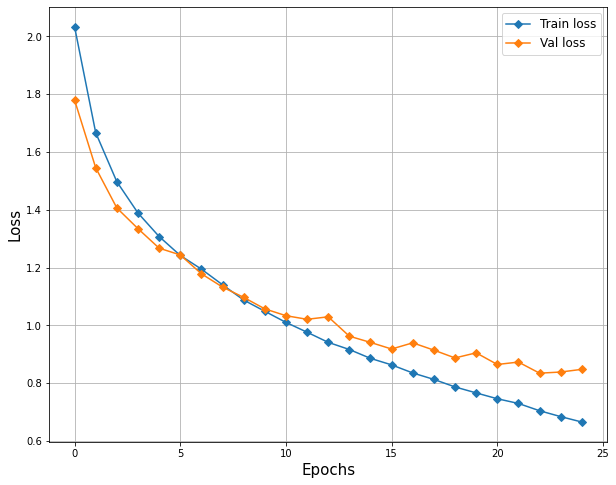

In [ ]:
plot_losses(train_losses, val_losses, EPOCHS)

### 4.2. Метрика

In [ ]:
def plot_accs(train_accs, val_accs, num_epochs):
  fig, ax = plt.subplots(figsize=(10, 8))
  epochs = list(range(num_epochs))
  ax.plot(epochs, train_accs, '-D', label='Train accuracy')
  ax.plot(epochs, val_accs, '-D', label='Val accuracy')
  ax.set_xlabel('Epochs', fontsize=15)
  ax.set_ylabel('Accuracy', fontsize=15)
  leg = ax.legend(prop={"size":12})
  ax.grid()

  plt.show()

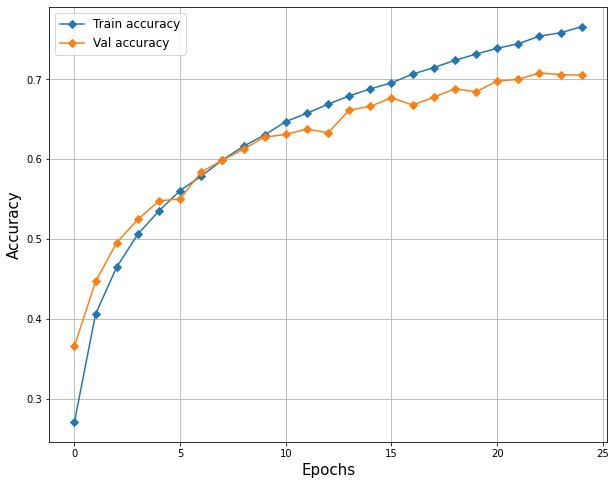

In [ ]:
plot_accs(train_accs, val_accs, EPOCHS)

## 5. Выводы

Видно, что значения лосса на тренировке и валидации примерно одинаковы. Это также касается метрики, которая составляет примерно 70 % на валидации. Безусловно, этот результат можно улучшить, увеличив количество сверточных слоев.